In [1]:
import numpy as np
import pandas as pd
from os import makedirs
from os.path import join, exists
from nilearn.plotting import plot_connectome, plot_roi, find_parcellation_cut_coords
import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr

In [2]:

def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [3]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102']
kappa_upper = 0.21
kappa_lower = 0.31

sink_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data/output'
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'

shen = '/home/kbott006/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/home/kbott006/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'craddock2012']

tasks = {'reas': [{'conditions': ['Reasoning', 'Baseline']},
                  {'runs': [0,1]}],
         'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0,1]}], 
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                  {'runs': [0,1,2]}]}

sessions = [0,1]
sesh = ['pre', 'post']
conds = ['high-level', 'lower-level']

lab_notebook_dir = '/home/kbott006/lab_notebook/'
index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks], 
                                   names=['subject', 'session', 'task', 'condition', 'mask'])
lab_notebook = pd.DataFrame(index=index, columns=['start', 'end', 'errors'])

index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks], 
                                   names=['subject', 'session', 'task', 'condition', 'mask'])

In [4]:
shen_df = pd.read_csv(join(data_dir, 'physics-learning-tasks_graphtheory_shen+craddock_nodal.csv'), index_col=0, header=0)
shen_df.rename({'Unnamed: 1': 'session', 'Unnamed: 2': 'task', 'Unnamed: 3': 'condition'}, axis=1, inplace=True)
#shen_rest_df = pd.read_csv(join(sink_dir, 'rest-shen-triplenetwork.csv'), index_col=0, header=0)
#shen_rest_df.rename({'Unnamed: 1': 'session'}, axis=1, inplace=True)

In [5]:
shen_df.head()

,session,task,condition,mask,lEff0,lEff1,lEff2,lEff3,lEff4,lEff5,...,lEff258,lEff259,lEff260,lEff261,lEff262,lEff263,lEff264,lEff265,lEff266,lEff267
subject,,,,,,,,,,,,,,,,,,,,,
101,0,retr,high-level,shen2015,0.016342,0.014857,0.016667,0.014604,0.016563,0.016168,...,0.014540,0.013297,0.013285,0.014186,0.013339,0.013962,0.013770,0.014123,0.013676,0.013650
101,0,retr,high-level,craddock2012,0.014511,0.014408,0.015520,0.015136,0.014026,0.014512,...,0.015358,0.013653,0.014506,0.013741,0.014441,0.016137,0.014428,0.014819,0.015247,0.012317
101,0,retr,lower-level,shen2015,0.025559,0.021059,0.022732,0.020410,0.020912,0.021074,...,0.021051,0.021036,0.021435,0.020899,0.020890,0.006949,0.021168,0.022640,0.021129,0.024030
101,0,retr,lower-level,craddock2012,0.021981,0.022321,0.021616,0.021308,0.021257,0.023326,...,0.021221,0.021530,0.021658,0.021272,0.014895,0.025117,0.021989,0.022741,0.021813,0.021865
101,0,fci,high-level,shen2015,0.013908,0.012726,0.013784,0.011988,0.013910,0.014731,...,0.012938,0.012158,0.012713,0.012061,0.012104,0.011832,0.012480,0.013026,0.013243,0.013715


rest_pre = shen_rest_df[shen_rest_df['session'] == 0].dropna()
rest_post = shen_rest_df[shen_rest_df['session'] == 1].dropna()

In [6]:
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
b_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data.csv'), index_col=0, header=0)

df_f = b_df[b_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = b_df[b_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

In [7]:
#rest_fd = pd.read_csv('/Users/Katie/Dropbox/Projects/physics-retrieval/data/avg-fd-per-run-rest_2019-05-31.csv', index_col=0, header=0)
#rest_fd['normalized fd'] = (rest_fd['average fd']-np.mean(rest_fd['average fd']))/np.std(rest_fd['average fd'])

In [8]:
#df_pivot = rest_fd.reset_index()
#rest_fd = df_pivot.pivot(index='subject', columns='session', values='normalized fd')
#rest_fd.rename({'pre': 'pre rest fd', 'post': 'post rest fd'}, axis=1, inplace=True)

In [9]:
fd = pd.read_csv(join('/Users/Katie/Dropbox/Projects/physics-retrieval/data/avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
reas_fd = fd[fd['task'] == 'reas']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'high-level'].reset_index()
reas_inf_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_inf_fd.rename({'pre': 'pre infr reas fd', 'post': 'post infr reas fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'lower-level'].reset_index()
reas_base_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_base_fd.rename({'pre': 'pre base reas fd', 'post': 'post base reas fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

In [10]:
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

In [11]:
big_df = pd.concat([b_df, 
                    retr_phys_fd, 
                    retr_genr_fd, 
                    fci_phys_fd, 
                    fci_ctrl_fd, 
                    reas_base_fd, 
                    reas_inf_fd, 
                    #rest_fd
                   ], axis=1)

In [12]:
fci_shen = shen_df[shen_df['mask'] == 'shen2015']
fci_shen = fci_shen[fci_shen['task'] == 'fci']
fci_shen_pre = fci_shen[fci_shen['session'] == 0]
fci_shen_pre_phys = fci_shen_pre[fci_shen_pre['condition'] == 'high-level']
fci_shen_pre_ctrl = fci_shen_pre[fci_shen_pre['condition'] == 'lower-level']
fci_shen_post = fci_shen[fci_shen['session'] == 1]
fci_shen_post_phys = fci_shen_post[fci_shen_post['condition'] == 'high-level']
fci_shen_post_ctrl = fci_shen_post[fci_shen_post['condition'] == 'lower-level']

In [13]:
retr_shen = shen_df[shen_df['mask'] == 'shen2015']
retr_shen = retr_shen[retr_shen['task'] == 'retr']
retr_shen_pre = retr_shen[retr_shen['session'] == 0]
retr_shen_pre_phys = retr_shen_pre[retr_shen_pre['condition'] == 'high-level']
retr_shen_pre_ctrl = retr_shen_pre[retr_shen_pre['condition'] == 'lower-level']
retr_shen_post = retr_shen[retr_shen['session'] == 1]
retr_shen_post_phys = retr_shen_post[retr_shen_post['condition'] == 'high-level']
retr_shen_post_ctrl = retr_shen_post[retr_shen_post['condition'] == 'lower-level']

In [14]:
reas_shen = shen_df[shen_df['mask'] == 'shen2015']
reas_shen = reas_shen[reas_shen['task'] == 'reas']
reas_shen_pre = reas_shen[reas_shen['session'] == 0]
reas_shen_pre_infr = reas_shen_pre[reas_shen_pre['condition'] == 'high-level']
reas_shen_pre_ctrl = reas_shen_pre[reas_shen_pre['condition'] == 'lower-level']
reas_shen_post = reas_shen[reas_shen['session'] == 1]
reas_shen_post_infr = reas_shen_post[reas_shen_post['condition'] == 'high-level']
reas_shen_post_ctrl = reas_shen_post[reas_shen_post['condition'] == 'lower-level']

In [15]:
fci_shen_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
fci_shen_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

fci_shen_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
fci_shen_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

retr_shen_pre_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
retr_shen_post_phys.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

retr_shen_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
retr_shen_post_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

reas_shen_pre_ctrl.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)
reas_shen_pre_infr.drop(['session', 'task', 'condition', 'mask'], axis=1, inplace=True)

#rest_pre.drop(['session'], axis=1, inplace=True)
#rest_post.drop(['session'], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
reas_shen_pre_infr.head()

,lEff0,lEff1,lEff2,lEff3,lEff4,lEff5,lEff6,lEff7,lEff8,lEff9,...,lEff258,lEff259,lEff260,lEff261,lEff262,lEff263,lEff264,lEff265,lEff266,lEff267
subject,,,,,,,,,,,,,,,,,,,,,
101,0.008609,0.008517,0.008813,0.008589,0.008773,0.009208,0.008929,0.008312,0.007725,0.009472,...,0.008383,0.008576,0.008376,0.008796,0.008406,0.007523,0.008457,0.008019,0.008210,0.008321
102,0.010325,0.009662,0.010215,0.010468,0.010284,0.010343,0.010233,0.010249,0.010598,0.010842,...,0.010084,0.010618,0.009647,0.009734,0.010028,0.010135,0.009912,0.010441,0.009709,0.009824
103,0.017500,0.017919,0.016859,0.017312,0.017481,0.017313,0.018403,0.018023,0.017367,0.017237,...,0.016817,0.017587,0.017761,0.016429,0.017500,0.018229,0.016219,0.000000,0.013908,0.017202
104,0.015105,0.015056,0.014439,0.015668,0.015562,0.016225,0.016667,0.016737,0.015858,0.016200,...,0.015726,0.015208,0.016258,0.015602,0.016258,0.015412,0.015519,0.000000,0.015287,0.015082
106,0.011785,0.011194,0.010826,0.011152,0.010742,0.011704,0.011683,0.012388,0.011459,0.010881,...,0.011197,0.012061,0.011322,0.011237,0.011560,0.009699,0.011790,0.010941,0.011995,0.011552


for column in rest_pre.columns:
    num = np.nonzero(rest_pre[column].values)[0].shape
    if num[0] <=  5:
        rest_pre.drop(column, axis=1, inplace=True)

for column in rest_post.columns:
    num = np.nonzero(rest_post[column].values)[0].shape
    if num[0] <= 5:
        rest_post.drop(column, axis=1, inplace=True)

sig_rest = {}
for iq in iqs:
    # RESTING STATE HOLLA
    drop_behav = set(big_df.index.values) - set(rest_pre.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           rest_pre.dropna(how='all').values, big_df[[ 'Age', 'F', 'pre rest fd']].drop(drop_behav, axis=0).sort_index().values)
    sig_rest['pre: {0}, rest'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(rest_post.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           rest_post.dropna(how='all').values, big_df[[ 'Age', 'F', 'post rest fd']].drop(drop_behav, axis=0).sort_index().values)
    sig_rest['post: {0}, rest'.format(iq)] = np.max(p[0])

sig_rest

In [22]:
sig = {}
for iq in iqs:
    drop_behav = set(big_df.index.values) - set(fci_shen_pre_phys.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           fci_shen_pre_phys.dropna(how='all').values, 
                           big_df[[ 'Age', 'F', 'pre phys fci fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, fci_phys'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(fci_shen_post_phys.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           fci_shen_post_phys.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post phys fci fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, fci_phys'.format(iq)] = np.max(p[0])
    
    drop_behav = set(big_df.index.values) - set(fci_shen_pre_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           fci_shen_pre_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'pre ctrl fci fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, fci_ctrl'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(fci_shen_post_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           fci_shen_post_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post ctrl fci fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, fci_ctrl'.format(iq)] = np.max(p[0])
    
    # RETR TASK
    drop_behav = set(big_df.index.values) - set(retr_shen_pre_phys.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           retr_shen_pre_phys.dropna(how='all').values, 
                           big_df[['Age', 'F', 'pre phys retr fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, retr_phys'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(retr_shen_post_phys.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           retr_shen_post_phys.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post phys retr fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, retr_phys'.format(iq)] = np.max(p[0])
    
    drop_behav = set(big_df.index.values) - set(retr_shen_pre_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           retr_shen_pre_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'pre gen retr fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, retr_genr'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(retr_shen_post_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           retr_shen_post_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post gen retr fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, retr_genr'.format(iq)] = np.max(p[0])
    
    # REAS TASK
    drop_behav = set(big_df.index.values) - set(reas_shen_pre_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           reas_shen_pre_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'pre base reas fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, reas_ctrl'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(reas_shen_pre_infr.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           reas_shen_pre_infr.dropna(how='all').values, 
                           big_df[['Age', 'F', 'pre infr reas fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['pre: {0}, reas_infr'.format(iq)] = np.max(p[0])
    
    drop_behav = set(big_df.index.values) - set(reas_shen_post_ctrl.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                           reas_shen_post_ctrl.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post base reas fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, reas_ctrl'.format(iq)] = np.max(p[0])
    drop_behav = set(big_df.index.values) - set(reas_shen_post_infr.dropna(how='all').index.values)
    p, t, _ = permuted_ols(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                           reas_shen_post_infr.dropna(how='all').values, 
                           big_df[['Age', 'F', 'post infr reas fd']].drop(drop_behav, axis=0).sort_index().values)
    sig['post: {0}, reas_infr'.format(iq)] = np.max(p[0])

In [23]:
for key in sig.keys():
    if sig[key] >= 1:
        print(key, sig[key])

pre: WMI, fci_phys 1.333525446721982
post: WMI, fci_ctrl 1.9788541282069245
pre: PSI, retr_phys 1.4921875555810318
pre: FSIQ, fci_phys 1.7799353392368076


In [ ]:
STOP

In [24]:
drop_behav = set(big_df.index.values) - set(fci_shen_pre_phys.dropna(how='all').index.values)
pWMIPREFCIP, tWMIPREFCIP, _ = permuted_ols(big_df['WMI1'].drop(drop_behav, axis=0).values, 
                       fci_shen_pre_phys.dropna(how='all').values, 
                       big_df[[ 'Age', 'F', 'pre phys fci fd']].drop(drop_behav, axis=0).sort_index().values)

drop_behav = set(big_df.index.values) - set(fci_shen_post_ctrl.dropna(how='all').index.values)
pWMIPOSFCIC, tMIPOSFCIC, _ = permuted_ols(big_df['WMI2'].drop(drop_behav, axis=0).values, 
                       fci_shen_post_ctrl.dropna(how='all').values, 
                       big_df[[ 'Age', 'F', 'post ctrl fci fd']].drop(drop_behav, axis=0).sort_index().values)

drop_behav = set(big_df.index.values) - set(retr_shen_pre_phys.dropna(how='all').index.values)
pPSIPRERETR, tPSIPRERETR, _ = permuted_ols(big_df['PSI1'].drop(drop_behav, axis=0).values, 
                       retr_shen_pre_phys.dropna(how='all').values, 
                       big_df[[ 'Age', 'F', 'pre phys retr fd']].drop(drop_behav, axis=0).sort_index().values)

drop_behav = set(big_df.index.values) - set(fci_shen_pre_phys.dropna(how='all').index.values)
pFSIQPREFCI, tFSIQPREFCI, _ = permuted_ols(big_df['FSIQ1'].drop(drop_behav, axis=0).values, 
                       fci_shen_pre_phys.dropna(how='all').values, 
                       big_df[[ 'Age', 'F', 'pre phys fci fd']].drop(drop_behav, axis=0).sort_index().values)

In [ ]:
pval = np.vstack((pWMIPREFCIP, pWMIPOSFCIC, pPSIPRERETR, pFSIQPREFCI))

In [25]:
sig_iq_task = ['preWMI-FCIphys', 'postWMI-FCIcontrol', 'prePSI-RETRphys', 'preFSIQ-FCIphys']
ind = pd.MultiIndex.from_product([sig_iq_task, ['p', 't']])
triplenetwork_sig = pd.DataFrame(index=ind, columns=fci_shen_pre_phys.columns)

In [26]:
triplenetwork_sig.at[('preWMI-FCIphys', 'p')] = pWMIPREFCIP
triplenetwork_sig.at[('preWMI-FCIphys', 't')] = tWMIPREFCIP

triplenetwork_sig.at[('postWMI-FCIcontrol', 'p')] = pWMIPOSFCIC
triplenetwork_sig.at[('postWMI-FCIcontrol', 't')] = tMIPOSFCIC

triplenetwork_sig.at[('prePSI-RETRphys', 'p')] = pPSIPRERETR
triplenetwork_sig.at[('prePSI-RETRphys', 't')] = tPSIPRERETR

triplenetwork_sig.at[('preFSIQ-FCIphys', 'p')] = pFSIQPREFCI
triplenetwork_sig.at[('preFSIQ-FCIphys', 't')] = tFSIQPREFCI

In [27]:
triplenetwork_sig.columns

Index(['5dmn-138dmn', '5dmn-140dmn', '5dmn-145dmn', '5dmn-174dmn',
       '5dmn-176dmn', '5dmn-178dmn', '5dmn-182dmn', '5dmn-183dmn',
       '5dmn-190dmn', '5dmn-203dmn',
       ...
       '221sal-200cen', '221sal-201cen', '221sal-163sal', '221sal-261sal',
       '221sal-169sal', '221sal-188sal', '221sal-152sal', '221sal-153sal',
       '221sal-124sal', '221sal-125sal'],
      dtype='object', length=2352)

## set columns to indices of a new empty matrix
### zeroes for all other indices
### plot connectome, using shen atlas to show where "dmn138" etc. are
## repeat with craddock data

In [28]:
index = []

for column in triplenetwork_sig.columns:
    index.append(column.split('-')[0])

In [29]:
regions = list(set(index))

In [53]:
sig_prewmi_fci_p = pd.DataFrame(index=regions, columns=regions)
sig_prewmi_fci_t = pd.DataFrame(index=regions, columns=regions)

sig_postwmi_fciC_p = pd.DataFrame(index=regions, columns=regions)
sig_postwmi_fciC_t = pd.DataFrame(index=regions, columns=regions)

sig_prepsi_retr_p = pd.DataFrame(index=regions, columns=regions)
sig_prepsi_retr_t = pd.DataFrame(index=regions, columns=regions)

sig_prefsi_fci_p = pd.DataFrame(index=regions, columns=regions)
sig_prefsi_fci_t = pd.DataFrame(index=regions, columns=regions)

In [54]:
for region1 in regions:
    for region2 in regions:
        try:
            sig_prewmi_fci_p.at[region1,region2] = triplenetwork_sig.loc[('preWMI-FCIphys', 'p')]['{0}-{1}'.format(region1, region2)]
            sig_prewmi_fci_t.at[region1,region2] = triplenetwork_sig.loc[('preWMI-FCIphys', 't')]['{0}-{1}'.format(region1, region2)]
            
            sig_postwmi_fciC_p.at[region1,region2] = triplenetwork_sig.loc[('postWMI-FCIcontrol', 'p')]['{0}-{1}'.format(region1, region2)]
            sig_postwmi_fciC_t.at[region1,region2] = triplenetwork_sig.loc[('postWMI-FCIcontrol', 't')]['{0}-{1}'.format(region1, region2)]

            sig_prepsi_retr_p.at[region1,region2] = triplenetwork_sig.loc[('prePSI-RETRphys', 'p')]['{0}-{1}'.format(region1, region2)]
            sig_prepsi_retr_t.at[region1,region2] = triplenetwork_sig.loc[('prePSI-RETRphys', 't')]['{0}-{1}'.format(region1, region2)]

            sig_prefsi_fci_p.at[region1,region2] = triplenetwork_sig.loc[('preFSIQ-FCIphys', 'p')]['{0}-{1}'.format(region1, region2)]
            sig_prefsi_fci_t.at[region1,region2] = triplenetwork_sig.loc[('preFSIQ-FCIphys', 't')]['{0}-{1}'.format(region1, region2)]
        
        except Exception as e:
            pass

In [55]:
sig_prewmi_fci_t.fillna(0, inplace=True)
sig_prewmi_fci_p.fillna(0, inplace=True)

sig_postwmi_fciC_t.fillna(0, inplace=True)
sig_postwmi_fciC_p.fillna(0, inplace=True)

sig_prepsi_retr_t.fillna(0, inplace=True)
sig_prepsi_retr_p.fillna(0, inplace=True)

sig_prefsi_fci_t.fillna(0, inplace=True)
sig_prefsi_fci_p.fillna(0, inplace=True)

In [84]:
for i in sig_prewmi_fci_p.index:
    if len(i) == 5:
        sig_prewmi_fci_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prewmi_fci_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postwmi_fciC_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postwmi_fciC_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prepsi_retr_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prepsi_retr_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prefsi_fci_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prefsi_fci_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prewmi_fci_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prewmi_fci_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postwmi_fciC_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postwmi_fciC_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prepsi_retr_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prepsi_retr_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prefsi_fci_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prefsi_fci_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)

for i in sig_prewmi_fci_p.columns:
    if len(i) == 5:
        sig_prewmi_fci_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prewmi_fci_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postwmi_fciC_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postwmi_fciC_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prepsi_retr_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prepsi_retr_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prefsi_fci_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prefsi_fci_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prewmi_fci_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prewmi_fci_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postwmi_fciC_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postwmi_fciC_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prepsi_retr_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prepsi_retr_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prefsi_fci_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prefsi_fci_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)

In [85]:
sig_prewmi_fci_p.sort_index(inplace=True)
sig_prewmi_fci_p.sort_index(axis=1,inplace=True)

sig_postwmi_fciC_p.sort_index(inplace=True)
sig_postwmi_fciC_p.sort_index(axis=1,inplace=True)

sig_prepsi_retr_p.sort_index(inplace=True)
sig_prepsi_retr_p.sort_index(axis=1,inplace=True)

sig_prefsi_fci_p.sort_index(inplace=True)
sig_prefsi_fci_p.sort_index(axis=1,inplace=True)


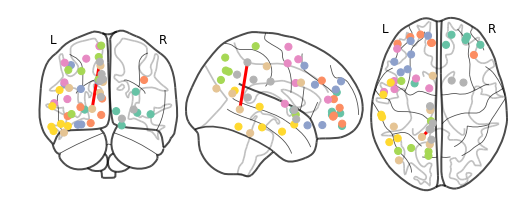

In [86]:
coordinates = find_parcellation_cut_coords(labels_img='/Users/Katie/Dropbox/Data/templates/shen2015/shen_triplenetwork.nii.gz')
q = plot_connectome(sig_prewmi_fci_p.values, coordinates, edge_threshold=1.)
q.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/pre_wmi_fci-physics_conn_sig.png', dpi=300)

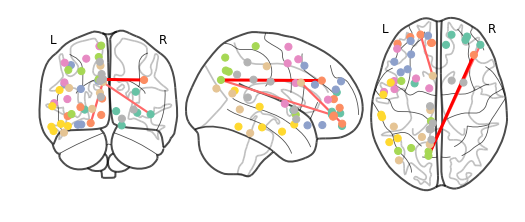

In [87]:
r = plot_connectome(sig_postwmi_fciC_p.values, coordinates, edge_threshold=1.)
r.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/post_wmi_fci-control_conn_sig.png', 
          dpi=300)

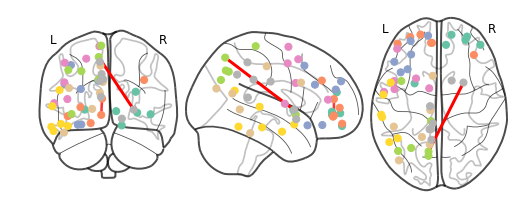

In [88]:
s = plot_connectome(sig_prepsi_retr_p.values, coordinates, edge_threshold=1.)
s.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/pre_psi_retr-physics_conn_sig.png', 
          dpi=300)

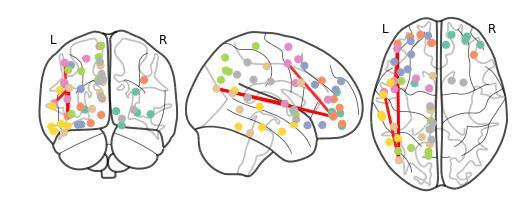

In [89]:
plot_connectome(sig_prefsi_fci_p.values, coordinates, edge_threshold=1.)
s.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/pre_fsiq_fci-physics_conn_sig.png', 
          dpi=300)

In [90]:
print('Pre-instruction FCI connections related to WMI:')
for i in sig_prewmi_fci_p.index:
    for j in sig_prewmi_fci_p.columns:
        if sig_prewmi_fci_p.at[i,j] >= 1:
            print(i,j)

Pre-instruction FCI connections related to WMI:
203dmn 225dmn
225dmn 203dmn


In [91]:
print('Post-instruction FCI (control) connections related to WMI:')
for i in sig_postwmi_fciC_p.index:
    for j in sig_postwmi_fciC_p.columns:
        if sig_postwmi_fciC_p.at[i,j] >= 1:
            print(i,j)

Post-instruction FCI (control) connections related to WMI:
009cen 174dmn
125sal 174dmn
138dmn 218dmn
174dmn 009cen
174dmn 125sal
218dmn 138dmn


In [92]:
print('Pre-instruction retrieval (physics) connections related to PSI:')
for i in sig_prepsi_retr_p.index:
    for j in sig_prepsi_retr_p.columns:
        if sig_prepsi_retr_p.at[i,j] >= 1:
            print(i,j)

Pre-instruction retrieval (physics) connections related to PSI:
124sal 139cen
139cen 124sal
177cen 227dmn
227dmn 177cen


In [93]:
print('Pre-instruction retrieval (physics) connections related to FSIQ:')
for i in sig_prefsi_fci_p.index:
    for j in sig_prefsi_fci_p.columns:
        if sig_prefsi_fci_p.at[i,j] >= 1:
            print(i,j)

Pre-instruction retrieval (physics) connections related to FSIQ:
142cen 164cen
142cen 201cen
162cen 201cen
164cen 142cen
201cen 142cen
201cen 162cen


In [ ]:
for conn in fci_shen_post_phys.columns:
    for iq in iqs:
        drop_behav = set(big_df.index.values) - set(fci_shen_pre_phys.dropna(how='all').index.values)
        corr = pearsonr(big_df['{0}1'.format(iq)].drop(drop_behav, axis=0).values, 
                       fci_shen_pre_phys[conn].dropna(how='all').values)
        if corr[1] <= adj_alpha:
            print('pre',iq, conn, corr)
        drop_behav = set(big_df.index.values) - set(fci_shen_post_phys.dropna(how='all').index.values)
        corr = pearsonr(big_df['{0}2'.format(iq)].drop(drop_behav, axis=0).values, 
                       fci_shen_post_phys[conn].dropna(how='all').values)
        if corr[1] <= adj_alpha:
            print('post', iq, conn, corr)